In [54]:
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 

from sklearn.datasets import fetch_california_housing 
from sklearn.model_selection import ShuffleSplit, train_test_split ,GridSearchCV,learning_curve
from sklearn.ensemble import GradientBoostingRegressor 

%matplotlib inline 

In [55]:
np.random.seed(sum(map(ord, "aesthetics"))) 
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 5) 
#Pandas options 
pd.set_option('display.notebook_repr_html', False) 
pd.set_option('display.max_columns', 40) 
pd.set_option('display.max_rows', 25) 
pd.options.display.max_colwidth = 50

## 数据获取

In [5]:
cal=fetch_california_housing()

In [56]:
type(cal)

sklearn.datasets.base.Bunch

In [6]:
print(cal.keys())

dict_keys(['DESCR', 'feature_names', 'target', 'data'])


In [7]:
#DESCR contains a description of the dataset 
print(cal.DESCR)

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.




## 模型

In [8]:
X_train, X_test, y_train, y_test = train_test_split(cal.data, cal.target)
print(X_train.shape, X_test.shape)

(15480, 8) (5160, 8)


In [9]:
gbrt=GradientBoostingRegressor(n_estimators=100)
gbrt.fit(X_train, y_train)
y_pred=gbrt.predict(X_test)

In [10]:
#important each of the features are 
print("Feature Importances")
print(gbrt.feature_importances_)
#R-squared value for train/test
print("R-squared for Train: %.2f" %gbrt.score(X_train, y_train))
print("R-squared for Test: %.2f" %gbrt.score(X_test, y_test))

Feature Importances
[ 0.18720714  0.0566953   0.04063991  0.03435635  0.02865885  0.09298566
  0.27320348  0.2862533 ]
R-squared for Train: 0.81
R-squared for Test: 0.77


下面进行grid search+cross-validation选择最佳超参数，我们定义了一个函数来进行处理

In [11]:
def GradientBooster(param_grid, n_jobs):
    estimator = GradientBoostingRegressor()
    
    #use ShuffleSpit, but you can use KFold also
    cv = ShuffleSplit(n_splits=10, test_size=0.2,random_state=0)

    #grid search
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs) 

    classifier.fit(X_train, y_train) 

    #best estimator
    print("Best Estimator learned through GridSearch")
    print(classifier.best_estimator_)
    return cv, classifier.best_estimator_

使用learning curve来理解模型的variance与bias

In [ ]:
learning_curve?

In [12]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [13]:
param_grid={'n_estimators':[100], 
    'learning_rate': [0.1,0.05, 0.02, 0.01],
    'max_depth':[6,4],
    'min_samples_leaf':[3,5,9,17],
    'max_features':[1.0,0.3,0.1] }

n_jobs=-1

cv,best_est=GradientBooster(param_grid, n_jobs)

Best Estimator learned through GridSearch
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=1.0,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=5, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)


In [14]:
print("Best Estimator Parameters")
print("---------------------------")
print("n_estimators: %d" %best_est.n_estimators)
print("max_depth: %d" %best_est.max_depth)
print("Learning Rate: %.1f" %best_est.learning_rate)
print("min_samples_leaf: %d" %best_est.min_samples_leaf)
print("max_features: %.1f" %best_est.max_features)
print("Train R-squared: %.2f" %best_est.score(X_train,y_train))
print("Test R-squared: %.2f" %best_est.score(X_test,y_test))

Best Estimator Parameters
---------------------------
n_estimators: 100
max_depth: 6
Learning Rate: 0.1
min_samples_leaf: 5
max_features: 1.0
Train R-squared: 0.90
Test R-squared: 0.82


<module 'matplotlib.pylab' from 'C:\\Anaconda\\envs\\py35\\lib\\site-packages\\matplotlib\\pylab.py'>

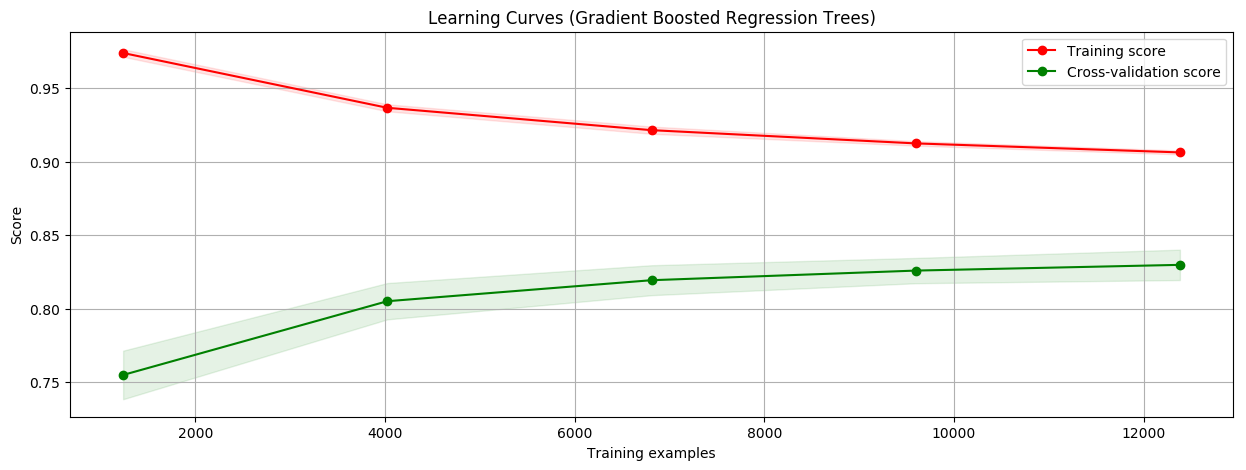

In [15]:
title = "Learning Curves (Gradient Boosted Regression Trees)"
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth, 
                                      learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
                                      max_features=best_est.max_features)
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)

In [16]:
1000个estimator?

<module 'matplotlib.pylab' from 'C:\\Anaconda\\envs\\py35\\lib\\site-packages\\matplotlib\\pylab.py'>

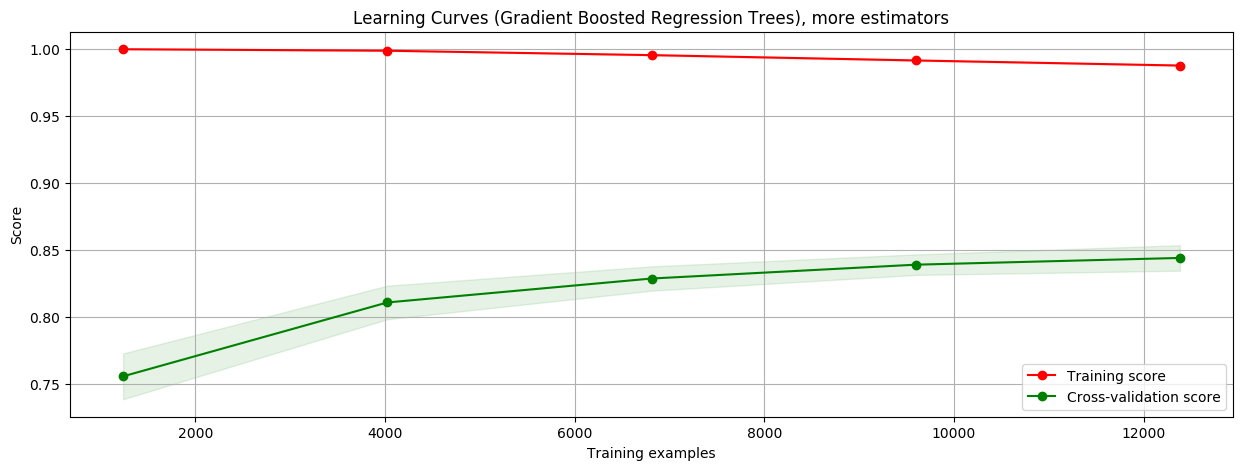

In [17]:
title = "Learning Curves (Gradient Boosted Regression Trees), more estimators"
estimator = GradientBoostingRegressor(n_estimators=1000, max_depth=best_est.max_depth, 
                                      learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
                                      max_features=best_est.max_features)
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)

C:\Anaconda\envs\py35\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


<module 'matplotlib.pylab' from 'C:\\Anaconda\\envs\\py35\\lib\\site-packages\\matplotlib\\pylab.py'>

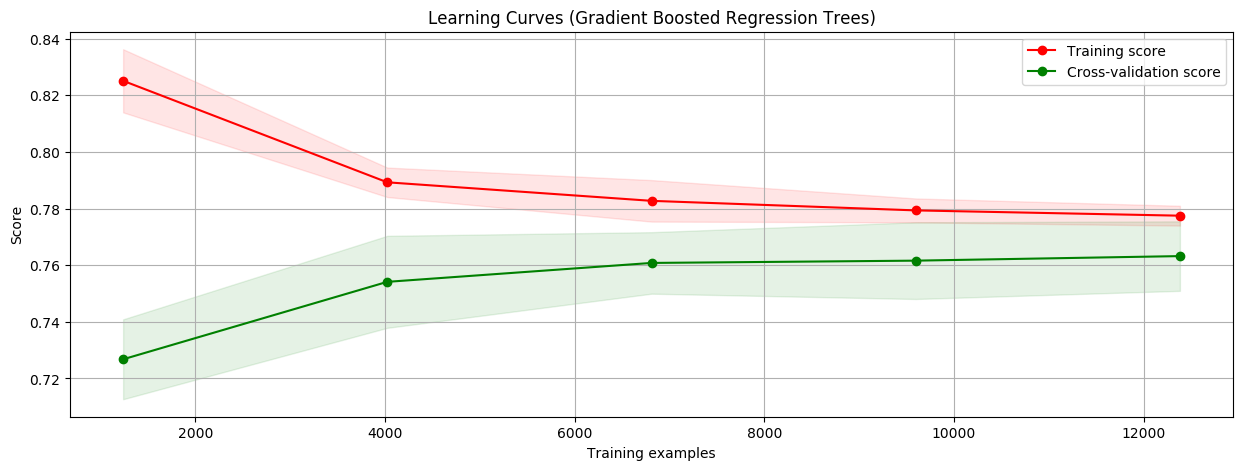

In [43]:
title = "Learning Curves (Gradient Boosted Regression Trees)"

#only use n_estimators and learning_rate
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, learning_rate=best_est.learning_rate)

#Calling fit on the estimator so we can transform the X matrices. 
estimator.fit(X_train, y_train) 

#Trimming feature matrices to include only those features that are more important than the mean of all importances.
X_train_trim=estimator.transform(X_train, threshold='mean')
#Trimming test as well in case we end up going with this model as final. 
X_test_trim=estimator.transform(X_test, threshold='mean') 

#Re-plotting Learning cruves. 
plot_learning_curve(estimator, title, X_train_trim, y_train, cv=cv, n_jobs=n_jobs)

(<matplotlib.figure.Figure at 0xb478208>,
  <matplotlib.axes._subplots.AxesSubplot at 0xc18f6a0>])

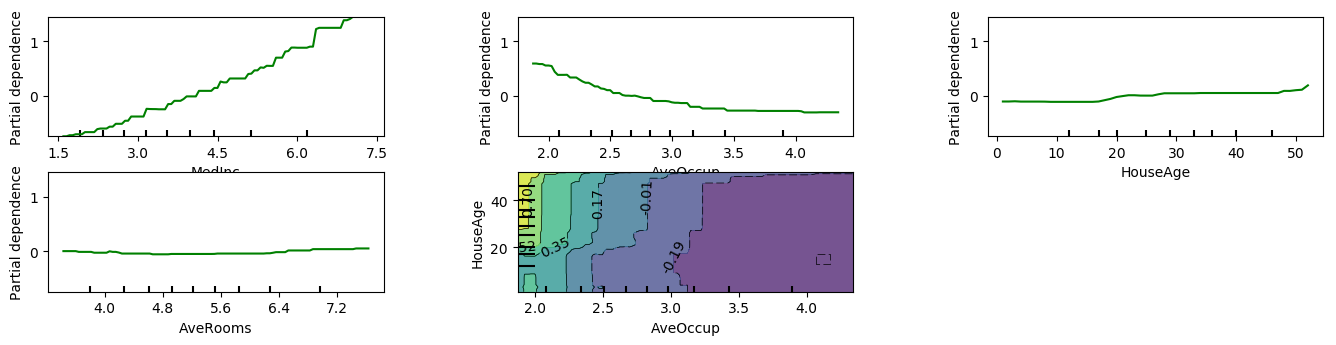

In [51]:
from sklearn.ensemble import partial_dependence 

features=['MedInc','AveOccup','HouseAge','AveRooms',('AveOccup','HouseAge')]
partial_dependence.plot_partial_dependence(estimator,X_train,features=features,feature_names=cal.feature_names)

In [45]:
cal.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']